***Libraries***

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2024-05-11 14:27:21.780950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 14:27:21.781042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 14:27:21.922457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Image/Masks Loader Function**

In [3]:
def load_images_and_masks(images_path, masks_path):
    images = [] #images list
    masks = [] #masks list
    image_files = sorted(glob.glob(images_path))  #get sorted images
    mask_files = sorted(glob.glob(masks_path)) #get sorted masks
 
    #Iterate over each image and mask
    for image_file, mask_file in zip(image_files, mask_files):
        image = cv2.imread(image_file) #read image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #change color to RGB if not present
        image = cv2.resize(image, (128, 128)) # resize to 128 by 128 pixels
        image = image / 255.0 #normalize the image pixels from range [0-1]
        images.append(image) #append colored/normalized image to the list

        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) # read the mask in greyscale image
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST) #used interpolation here to ensure only 3 classes are present( bg,optical cup,optical disk)
        mask = mask / 255.0 # normalized the mask
        mask = np.expand_dims(mask, axis=-1) #additional dimension to match 3 dimensions input of model
        masks.append(mask) #append mask to image
    
    return images, masks #return image and masks



**Dataset and Data Loader**

In [4]:

datasets = {
    'Glaucoma Images': {
        'images': '/kaggle/input/dip-dataset/DIP Dataset/images/*.jpg',
        'masks': '/kaggle/input/dip-dataset/DIP Dataset/masks/*.png'
    },
}

all_images = [] # list to store images
all_masks = [] #list to store masks

#load images and masks from dataset 
for dataset in datasets.values():
    images, masks = load_images_and_masks(dataset['images'], dataset['masks'])
    all_images.extend(images) #add newly iterated images to list
    all_masks.extend(masks) #add newly iterated masks to list
       
images_array = np.array(all_images) #convert to array format for further computation
masks_array = np.array(all_masks, dtype="float32")

**Masks Labelling and One hot Encoding**

In [5]:
label_encoder = LabelEncoder() #to encode integer features to numeric labels
num_images, num_channels, height, width = masks_array.shape #extract details of masks array
masks_reshaped = masks_array.reshape(-1, 1) #reshape to 2d to match input of label encoder
masks_reshaped_encoded = label_encoder.fit_transform(masks_reshaped) #encode masks using label encoder
masks_encoded_original_shape = masks_reshaped_encoded.reshape(num_images, num_channels, height, width) # restore original dimensions
masks_categorical = to_categorical(masks_encoded_original_shape, num_classes=3) # to do one hot encoding of the numeric labels

X_train, X_test, y_train, y_test = train_test_split(images_array, masks_categorical, test_size=0.20)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Train test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images_array, masks_categorical, test_size=0.25) # used to divide images for training and testing purposes

**UNET MODEL ARCHITECTURE**

In [7]:
import tensorflow as tf

# convolutional block
def convolution_block(input_layer, num_filters):
    # First convolution layer
    conv_layer = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input_layer) #keep the size of filter 3x3 
    conv_layer = tf.keras.layers.BatchNormalization()(conv_layer) #batch normalization for stabilization
    conv_layer = tf.keras.layers.Activation("relu")(conv_layer) #relu activation function
    
    # Second convolution layer
    conv_layer = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv_layer)
    conv_layer = tf.keras.layers.BatchNormalization()(conv_layer)
    conv_layer = tf.keras.layers.Activation("relu")(conv_layer)
    return conv_layer

# encoder block
def encoder_block(input_layer, num_filters):
    # Convolutional block
    skip_connection = convolution_block(input_layer, num_filters) #skip connections to preserve features
    
    # Max pooling layer
    pooled_layer = tf.keras.layers.MaxPool2D((2, 2))(skip_connection)# pool layer to localize features 
    return skip_connection, pooled_layer

# Define decoder block
def decoder_block(input_layer, skip_connection, num_filters):
    # Upsampling layer
    upsampled_layer = tf.keras.layers.Conv2DTranspose(
        num_filters, (2, 2), strides=2, padding="same"
    )(input_layer)
    
    # Concatenate skip connection
    concatenated_layer = tf.keras.layers.Concatenate()([upsampled_layer, skip_connection])
    
    # Convolutional block
    conv_layer = convolution_block(concatenated_layer, num_filters)
    return conv_layer

# Build U-Net model
def build_Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder(Image gets smaller and smaller)
    skip1, pool1 = encoder_block(inputs, 32) #number of filters as 32
    skip2, pool2 = encoder_block(pool1, 64) #filters increased to 64 and using previous encoder block output
    skip3, pool3 = encoder_block(pool2, 128)#filters increased to 128 and using previous encoder block output
    skip4, pool4 = encoder_block(pool3, 256)#filters increased to 256 and using previous encoder block output

    # Bridge
    bridge = convolution_block(pool4, 512) #bridge to connect encoder to decoder block 

    # Decoder(Image gets restored to orignal size but segmented)
    decode1 = decoder_block(bridge, skip4, 256)#filters decreased to 256 and using previous bridge block output
    decode2 = decoder_block(decode1, skip3, 128)
    decode3 = decoder_block(decode2, skip2, 64)
    decode4 = decoder_block(decode3, skip1, 32)
    
    # Output layer
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="softmax")(decode4) #softmax function to get probabilites
    
    # Define the model
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# Early stopping callback if model stops converging
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Build and compile the model
unet_model = build_Unet((128, 128, 3))
unet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "Recall", "Precision"])
unet_model.summary()

# Train the model
unet_result = unet_model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[callback])


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,939 (29.65 MB)

 Trainable params: 7,766,051 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

Epoch 1/30


2024-05-11 14:33:59.685620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.72281, expected 3.18193
2024-05-11 14:33:59.685678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.60587, expected 3.06498
2024-05-11 14:33:59.685687: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.72594, expected 3.18505
2024-05-11 14:33:59.685695: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.12739, expected 3.58651
2024-05-11 14:33:59.685703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.9109, expected 3.37001
2024-05-11 14:33:59.685711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 33: 3.74419, expected 3.20331
2024-05-11 14:33:59.685719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43: 3.65307, expected 3.11219
2024-05-11 14:33:59.685729: E external/local_xla/xla

 3/97 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - Precision: 0.0819 - Recall: 0.0578 - accuracy: 0.1466 - loss: 1.7251

I0000 00:00:1715438054.661984     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - Precision: 0.8480 - Recall: 0.7508 - accuracy: 0.8186 - loss: 0.6079

2024-05-11 14:34:22.999084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.46814, expected 3.72252
2024-05-11 14:34:22.999139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 6.4079, expected 5.66229
2024-05-11 14:34:22.999149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 6.41111, expected 5.66549
2024-05-11 14:34:22.999159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 5.4145, expected 4.66888
2024-05-11 14:34:22.999168: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 5.06218, expected 4.31657
2024-05-11 14:34:22.999175: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 4.92423, expected 4.17861
2024-05-11 14:34:22.999183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32775: 4.59546, expected 3.84984
2024-05-11 14:34:22.999191: E

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - Precision: 0.8491 - Recall: 0.7525 - accuracy: 0.8199 - loss: 0.6050 - val_Precision: 0.9689 - val_Recall: 0.9258 - val_accuracy: 0.9464 - val_loss: 0.3889
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - Precision: 0.9924 - Recall: 0.9884 - accuracy: 0.9905 - loss: 0.0988 - val_Precision: 0.9843 - val_Recall: 0.9824 - val_accuracy: 0.9832 - val_loss: 0.1245
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - Precision: 0.9930 - Recall: 0.9919 - accuracy: 0.9925 - loss: 0.0486 - val_Precision: 0.9853 - val_Recall: 0.9842 - val_accuracy: 0.9847 - val_loss: 0.0795
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - Precision: 0.9935 - Recall: 0.9929 - accuracy: 0.9932 - loss: 0.0319 - val_Precision: 0.9909 - val_Recall: 0.9896 - val_accuracy: 0.9902 - val_loss: 0.0406
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - Precision: 0.9935 - Recall: 0.9930 - accuracy: 0.9932 - loss: 0.0259 - val_Precision: 0.9921 - val_Recall: 0.9911 - val_

**Model Accuracy on Test Dataset**

In [8]:
model_evaluation = unet_model.evaluate(X_test, y_test)
print(f"%\nAccuracy: {model_evaluation[1]*100:.4f} %")

2024-05-11 14:37:00.992041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-05-11 14:37:00.992132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-05-11 14:37:00.992142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-05-11 14:37:00.992153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-05-11 14:37:00.992171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-05-11 14:37:00.992193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-05-11 14:37:00.992269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-05-11 14:37:00.992277: E exte

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - Precision: 0.9959 - Recall: 0.9959 - accuracy: 0.9959 - loss: 0.0110
%
Accuracy: 99.5896 %


**Testing Model on Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


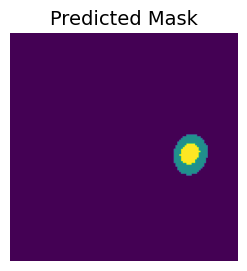

In [14]:
image = cv2.imread("/kaggle/input/origa-dataset/RIGA 200 Images/images/1.png") #image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #read image
image = cv2.resize(image, (128, 128)) #resize to match model dimensions
image = image / 255.0 #normalize is as initial input to model training was also normalized
image = np.expand_dims(image, axis=0) #add extra dimension for number of images
imad=np.array(image) #convert to array

predict=unet_model.predict(imad) #get model predictions

predicted_masks = (np.argmax(predict, axis=-1)).astype(np.uint8) # get the predicted mask with highest probability

#display Image
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(predicted_masks[0])
plt.title('Predicted Mask', fontsize=14)
plt.axis('off')

plt.show()

**CUP TO DISK RATIO**

In [13]:
mask = predicted_masks[0]
x=mask.flatten() #get 1d format
unique_values, counts = np.unique(x, return_counts=True)
ones_count=0
two_count=0
for value, count in zip(unique_values, counts):
    if(value==1):
        ones_count=count
    elif(value==2):
        two_count=count 
CDR=(two_count/ones_count)*100
rounded=round(CDR,2)
# Get unique values and their counts
print("CDR",CDR)

CDR 41.66666666666667
